In [1]:
!apt-get -y install unzip wget

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.1).
wget is already the newest version (1.19.4-1ubuntu2.2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [2]:
!unzip data.zip

Archive:  data.zip
replace lenta_sample.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/._lenta_sample.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

In [4]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
from IPython.display import Image
from IPython.core.display import HTML 
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
data = pd.read_csv('lenta_sample.csv')

In [6]:
data['len'] =  data['text'].apply(lambda x: len(x.split()))

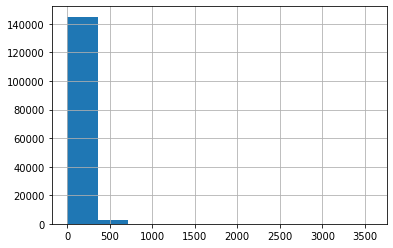

In [7]:
data['len'].hist()

In [8]:
data.dropna(subset=['topic', 'text'], inplace=True)

In [9]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [10]:
# словарь
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [11]:
# индексируем слова
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [12]:
id2word = {i:word for word, i in word2id.items()}

In [13]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, word2id, MAX_LEN, texts, targets):
        
        # храним сырой датасет
        # еще лучше можно сделать, если считывать из файла при генерации
        self.texts = [torch.LongTensor([word2id[w] for w in self.preprocess(t) if w in word2id][:MAX_LEN]) for t in texts]
        self.texts = torch.nn.utils.rnn.pad_sequence(self.texts, batch_first=True)
        
        # мы не считаем словарь прямо тут, т.к. нам нужно шерить словарь между трейном и валидацией
        self.word2id = word2id
        self.MAX_LEN = MAX_LEN
        self.length = len(texts)
        # таргеты можно сразу целиком выделить 
        
        self.target = torch.LongTensor(targets)

    def __len__(self):
        # нужно уметь возвращать длину датасета, в нашем случае это просто сделать
        # если не загружать данные целиком, а читать из файла - это может быть сложнее
        return self.length

    def __getitem__(self, index):

        # в index будут индексы от 0 до self.length
        # по ним мы достанем тексты, предобработаем,переведем в векторы, западим и вернем

        ids = self.texts[index]
        y = self.target[index]

        return ids, y
    
    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens

In [47]:
MAX_LEN = 149

In [48]:
texts = data.text.values
id2label = {i:l for i,l in enumerate(set(data.topic))}
label2id = {l:i for i,l in id2label.items()}
targets = [label2id[l] for l in data.topic]

In [49]:
train_texts, valid_texts, train_targets, valid_targets = train_test_split(texts, targets, test_size=0.05)

In [50]:
training_set = Dataset(word2id, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=256, shuffle=True, )

In [51]:
valid_set = Dataset(word2id, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=256, shuffle=True)

In [52]:
from sklearn.metrics import f1_score

def train(model, iterator, optimizer, criterion, print_every=1000):
    
    epoch_loss = []
    epoch_f1 = []
    
    model.train()  

    for i, (texts, ys) in enumerate(iterator):
        
        optimizer.zero_grad()   
        predictions = model(texts.to(device)).squeeze()  
        loss = criterion(predictions, ys.to(device))        
        
        
        
        loss.backward()
        optimizer.step()     
        preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
        y_true = ys.tolist()
        
        epoch_loss.append(loss.item())
        epoch_f1.append(f1_score(y_true, preds, average="micro"))
        
        if not (i+1) % print_every:
            print(f'Loss: {np.mean(epoch_loss)}; F1 measure: {np.mean(epoch_f1)}')
        
    return np.mean(epoch_f1)


def evaluate(model, iterator, criterion):
    
    epoch_loss = []
    epoch_f1 = []
    
    model.eval()  
    with torch.no_grad():
        for texts, ys in iterator:   

            predictions = model(texts.to(device)).squeeze()  
            loss = criterion(predictions, ys.to(device))        
            preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            y_true = ys.tolist()
            

            epoch_loss.append(loss.item())  
            epoch_f1.append(f1_score(y_true, preds, average="micro"))
            
    return np.mean(epoch_f1)# / len(iterator)

In [53]:
class Conv_layer_with_pad(nn.Module):
    
    def __init__(self, in_channels, out_channels, k_size=5, stride=1):
        
        super().__init__()          
        self.KERNEL_SIZE = k_size
        self.IN_CHANNELS = in_channels
        self.OUT_CHANNELS = out_channels
        self.STRIDE = stride
        self.conv = nn.Conv1d(self.IN_CHANNELS, 
                              self.OUT_CHANNELS, 
                              kernel_size=self.KERNEL_SIZE, 
                              stride=self.STRIDE, ) 
        
        self.act = nn.LeakyReLU()
        
    def forward(self, embedded):

        MAX_LEN = embedded.size(2)
        EXP_LEN = ((MAX_LEN-1)*self.STRIDE)+1+(self.KERNEL_SIZE-1)

        # нужно чтобы все сходилось, иначе выдавать ошибку
        assert not (EXP_LEN-MAX_LEN)%2, f"Не ровный паддинг! {EXP_LEN}"
        
        padded = F.pad(embedded, (int((EXP_LEN-MAX_LEN)/2), 
                                                   int((EXP_LEN-MAX_LEN)/2)))
        
        convoluted = self.conv(padded)

        
        return self.act(convoluted)

In [54]:
class Pool_layer_with_pad(nn.Module):
    
    def __init__(self, MAX_LEN):
        
        super().__init__()          
        self.KERNEL_SIZE = 2
        self.STRIDE = 2
                
        self.max_pool = nn.MaxPool1d(kernel_size=self.KERNEL_SIZE, 
                                     stride=self.STRIDE, padding=0)
        
        self.act = nn.LeakyReLU()
        
    def forward(self, embedded):
        
        pooled = self.max_pool(embedded)


        MAX_LEN = embedded.size(2) 
        OUT_LEN = pooled.size(2)
        #self.padding = (MAX_LEN*self.STRIDE - MAX_LEN + 1*(self.KERNEL_SIZE - 1) + 1 - self.STRIDE)//2
        padded = F.pad(pooled, (int((MAX_LEN - OUT_LEN)/2), 
                                                   int((MAX_LEN - OUT_LEN)/2)))

        return self.act(padded)

In [55]:
class Clf(nn.Module):
    
    def __init__(self, output_dim):
        
        super().__init__()          
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = 128
        self.KERNEL_SIZE = 7
        self.MAX_LEN = 150
        self.IN_CHANNELS = self.MAX_LEN
        self.OUT_CHANNELS = 32
        self.STRIDE = 1
        self.HIDDEN_FC = 64
        self.RNN_UNITS = 32
        
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        
        self.conv = Conv_layer_with_pad(self.EMB_DIM, self.OUT_CHANNELS) #cnn1 
        conv1_output = 16
        self.conv1 = Conv_layer_with_pad(self.OUT_CHANNELS, conv1_output, k_size = 2, stride=2) #cnn2
        self.max_pool = Pool_layer_with_pad(self.EMB_DIM)
        self.gru = nn.GRU(conv1_output, self.RNN_UNITS, batch_first=True, bidirectional=False, num_layers=4, dropout=0.25) #gru
        self.lstm = nn.LSTM(conv1_output, self.RNN_UNITS, batch_first=True, bidirectional=False, num_layers=2, dropout=0.5) #lstm
        self.relu = nn.ReLU()

        
        self.fc = nn.Linear(self.RNN_UNITS*2, output_dim)
        self.act = nn.LogSoftmax(1) 
        
        
    def forward(self, text):

        embedded = self.embedding(text)

        convoluted_1 = self.relu(self.max_pool(self.conv(embedded.permute(0, 2, 1)))) #первый сверточный слой с пулингом
        convoluted_2 = self.relu(self.max_pool(self.conv1(convoluted_1))).permute(0, 2, 1) #второй сверточный слой с пулингом
        gru = self.gru(convoluted_2)[0][:, -1]    #gru
        lstm = self.lstm(convoluted_2[:, -1:])[0][:, -1]    #lstm в другую сторону
        concated = torch.cat((gru, lstm), 1)
        hidden = torch.relu(self.fc(concated))
        outputs=self.act(hidden)

        return outputs

In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf(len(label2id))


optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss() 

model = model.to(device)
criterion = criterion.to(device)

In [57]:
f1s = []
f1s_eval = []

for i in range(10):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 100))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Loss: 2.523375160694122; F1 measure: 0.2011328125
Loss: 2.4616160345077516; F1 measure: 0.2079296875
Loss: 2.4400964601834616; F1 measure: 0.211875
Loss: 2.432223628759384; F1 measure: 0.21212890625
Loss: 2.4251161880493166; F1 measure: 0.21315625
Eval -  0.2926700191570881
1
Loss: 2.206180154085159; F1 measure: 0.3117578125
Loss: 2.1187306475639343; F1 measure: 0.33900390625
Loss: 2.052903882265091; F1 measure: 0.3553645833333333
Loss: 1.998747833967209; F1 measure: 0.374287109375
Loss: 1.9489891464710236; F1 measure: 0.393
Eval -  0.4756034482758621
2
Loss: 1.6351781129837035; F1 measure: 0.5073828125
Loss: 1.5929386240243912; F1 measure: 0.5165625
Loss: 1.566566261847814; F1 measure: 0.5200520833333333
Loss: 1.5399671468138694; F1 measure: 0.527236328125
Loss: 1.514286595582962; F1 measure: 0.5362890625
Eval -  0.5905657327586207
3
Loss: 1.3099603307247163; F1 measure: 0.61203125
Loss: 1.2837147623300553; F1 measure: 0.6162109375
Loss: 1.2659044277668; F1 measure: 0.62317708333333

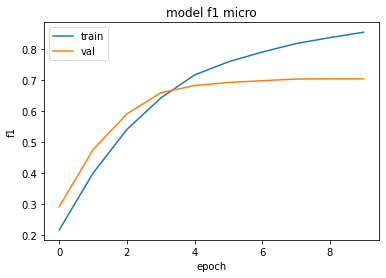

In [58]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [59]:
max(f1s_eval)

0.7030615421455939